In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
# read lena image grayscale
img = cv2.imread('lena.png', cv2.IMREAD_GRAYSCALE)

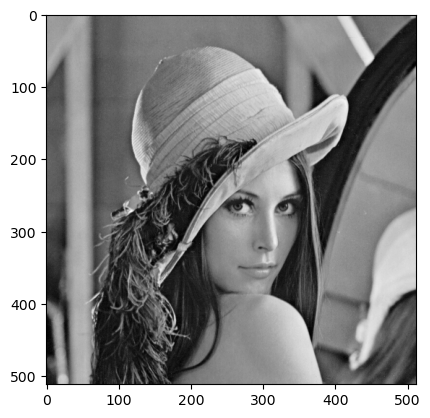

In [4]:
plt.imshow(img, cmap='gray')

## subband decomposition

In [5]:
# Filter coefficients
lp_analysis = np.array([-1, 2, 6, 2, -1]) / 8
hp_analysis = np.array([-1, 2, -1]) / 2
lp_synthesis = np.array([1, 2, 1]) / 2
hp_synthesis = np.array([-1, -2, 6, -2, -1]) / 8

In [6]:
def pad_and_convolve_line(array, filter):
    # padding
    array = np.pad(array, (len(filter) // 2, len(filter) // 2), 'reflect')
    # convolution
    output = np.convolve(array, filter, mode='valid')
    return output

def pad_and_convolve_img(input_img, filter):
    input_conv_img = np.zeros(input_img.shape)
    width = input_img.shape[1]
    height = input_img.shape[0]
    for i in range(height):
        input_conv_img[i] = pad_and_convolve_line(input_img[i], filter)
    return input_conv_img

def decomposition(input_img):
    input_decomposition_img = np.zeros(input_img.shape)
    # decomposition
    hf = pad_and_convolve_img(input_img, hp_analysis)
    lf = pad_and_convolve_img(input_img, lp_analysis)
    input_decomposition_img[:,0:input_img.shape[1]//2] = lf[:,1::2]
    input_decomposition_img[:,input_img.shape[1]//2:input_img.shape[1]] = hf[:,::2]
    return input_decomposition_img

def reconstruction(input_img):
    # reconstruction
    hf = input_img[:,input_img.shape[1]//2:input_img.shape[1]]
    lf = input_img[:,0:input_img.shape[1]//2]
    hf_recon = np.zeros((input_img.shape[0], input_img.shape[1]))
    hf_recon[:,::2] = hf
    lf_recon = np.zeros((input_img.shape[0], input_img.shape[1]))
    lf_recon[:,1::2] = lf
    hf_recon = pad_and_convolve_img(hf_recon, hp_synthesis)
    lf_recon = pad_and_convolve_img(lf_recon, lp_synthesis)
    recon_img = hf_recon + lf_recon
    return recon_img

def decomposition_to_4(input_img):
    # decomposition
    L1 = decomposition(input_img)
    L2 = decomposition(L1.T).T
    return L2

def reconstruction_from_4(input_img):
    # reconstruction
    L1 = reconstruction(input_img.T).T
    L2 = reconstruction(L1)
    return L2

def decomposition_to_specify_level(input_img, level):
    input_img = input_img.astype(np.float64)
    L = input_img.astype(np.float64)
    height = input_img.shape[0]
    width = input_img.shape[1]
    for i in range(1,level+1):
        # print(width//i, height//i)
        L[0:height//i,0:width//i] = decomposition_to_4(L[0:height//i,0:width//i])
    return L

def reconstruction_from_specify_level(input_img, level):
    input_img = input_img.astype(np.float64)
    L = input_img.astype(np.float64)
    height = input_img.shape[0]
    width = input_img.shape[1]
    for i in range(level):
        # print(width//(level-i), height//(level-i))
        L[0:height//(level-i),0:width//(level-i)] = reconstruction_from_4(L[0:height//(level-i),0:width//(level-i)])
    return L

In [7]:
l5_decomp = decomposition_to_specify_level(img, 5)
l5_recon = reconstruction_from_specify_level(l5_decomp, 5)
# calculate mse
mse = np.sum((img - l5_recon)**2) / (img.shape[0] * img.shape[1])
print('MSE: ', mse)

MSE:  0.0


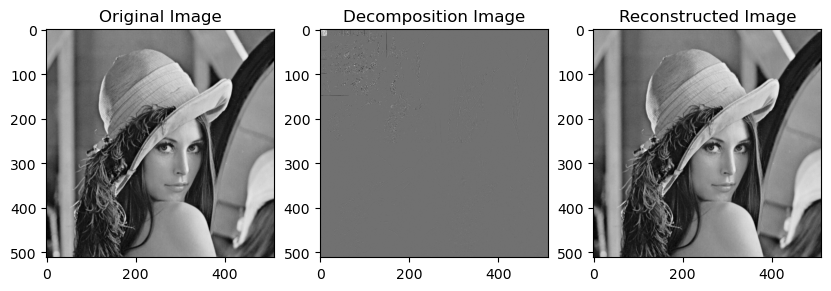

In [8]:
# plot img and l1_decomp
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(l5_decomp, cmap='gray')
plt.title('Decomposition Image')
plt.subplot(1,3,3)
plt.imshow(l5_recon, cmap='gray')
plt.title('Reconstructed Image')
plt.show()

---- verify the ezw result ----

MSE:  0.21792060108229744
PSNR:  54.747820727352334


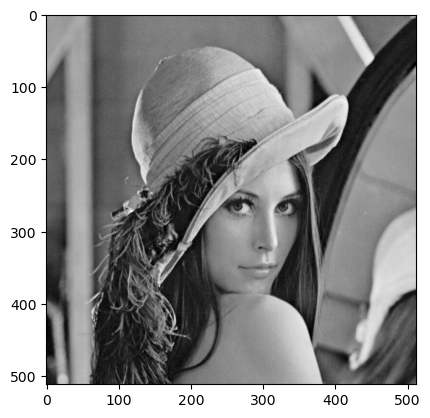

In [19]:
# np load recon_img_ezw.npy
recon_img_ezw = np.load('recon_img_ezw.npy')
recon_img_ezw_dwt = reconstruction_from_specify_level(recon_img_ezw, 5)
# cal psnr
mse = np.sum((img - recon_img_ezw_dwt)**2) / (img.shape[0] * img.shape[1])
psnr = 10 * np.log10(255**2 / mse)
print('MSE: ', mse)
print('PSNR: ', psnr)
plt.imshow(recon_img_ezw_dwt, cmap='gray')

---- verify the ezw result ----

## Quantize the DWT coefficients using a step size of q

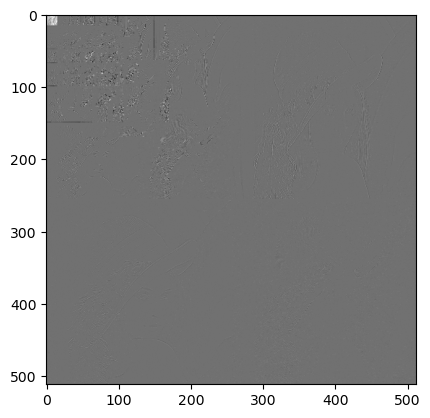

In [147]:
# quantization step = 1
l5_decomp_quant = np.round(l5_decomp)
plt.imshow(l5_decomp_quant, cmap='gray')

MSE:  0.3514260467928502


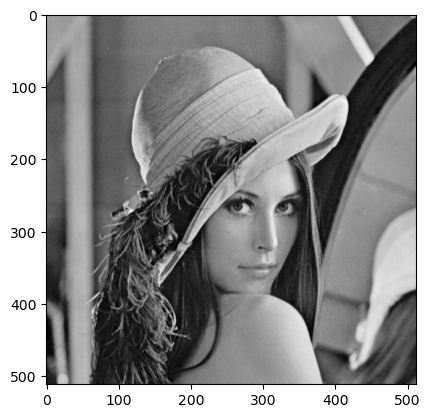

In [7]:
l5_recon = reconstruction_from_specify_level(l5_decomp_quant, 5)
# calculate mse
mse = np.sum((img - l5_recon)**2) / (img.shape[0] * img.shape[1])
print('MSE: ', mse)
plt.imshow(l5_recon, cmap='gray')

## Apply prediction to the lowest frequency subband; 

有问题，请勿使用！！

In [148]:
def HF_prediction(input_img):
    width = input_img.shape[1]
    height = input_img.shape[0]
    residual = np.zeros((height, width))
    # upscale
    upscaled_upper_left = input_img[0:height//2,0:width//2].repeat(2, axis=0).repeat(2, axis=1)
    # residual
    residual = input_img - upscaled_upper_left
    residual[0:height//2,0:width//2] = input_img[0:height//2,0:width//2]
    # plt.imshow(residual, cmap='gray')
    # plt.colorbar()
    return residual

def HF_prediction_recon(input_img):
    width = input_img.shape[1]
    height = input_img.shape[0]
    reconstruction_img = np.zeros((height, width))
    # upscale
    upscaled_upper_left = input_img[0:height//2,0:width//2].repeat(2, axis=0).repeat(2, axis=1)
    # residual
    reconstruction_img = input_img + upscaled_upper_left
    reconstruction_img[0:height//2,0:width//2] = input_img[0:height//2,0:width//2]
    # plt.imshow(residual, cmap='gray')
    # plt.colorbar()
    return reconstruction_img

In [149]:
def HF_prediction_full_img(input_img):
    height = input_img.shape[0]
    width = input_img.shape[1]
    prediction_output = np.zeros(input_img.shape)
    # round 1, top 512*512
    prediction_output = HF_prediction(prediction_input)
    # round 2, top 256*256
    prediction_output[0:256,0:256] = HF_prediction(prediction_input[0:height//2,0:width//2])
    # round 3, top 128*128
    prediction_output[0:128,0:128] = HF_prediction(prediction_input[0:height//4,0:width//4])
    # round 4, top 64*64
    prediction_output[0:64,0:64] = HF_prediction(prediction_input[0:height//8,0:width//8])
    return prediction_output

def HF_prediction_recon_full_img(input_img):
    height = input_img.shape[0]
    width = input_img.shape[1]
    prediction = input_img.copy()
    prediction_recon = np.zeros(input_img.shape)
    # round 1, 64*64
    prediction_recon[0:64,0:64] = HF_prediction_recon(prediction[0:height//8,0:width//8])
    prediction[0:64,0:64] = HF_prediction_recon(prediction[0:height//8,0:width//8])
    # round 2, 128*128
    prediction_recon[0:128,0:128] = HF_prediction_recon(prediction[0:height//4,0:width//4])
    prediction[0:128,0:128] = HF_prediction_recon(prediction[0:height//4,0:width//4])
    # round 3, 256*256
    prediction_recon[0:256,0:256] = HF_prediction_recon(prediction[0:height//2,0:width//2])
    prediction[0:256,0:256] = HF_prediction_recon(prediction[0:height//2,0:width//2])
    # round 4, 512*512
    prediction_recon = HF_prediction_recon(prediction)
    return prediction_recon

MSE:  0.0


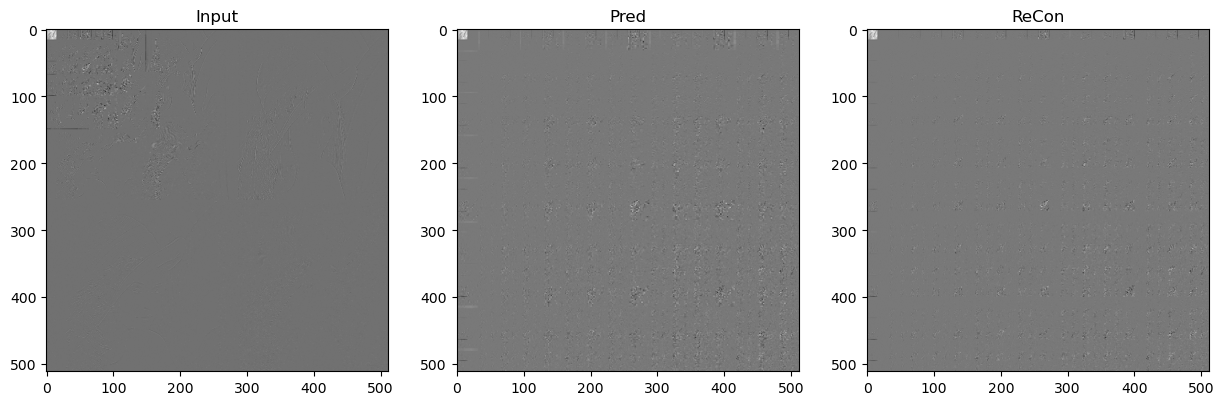

In [150]:
lf_prediction = HF_prediction_full_img(l5_decomp_quant)
pred_test_output = HF_prediction_recon_full_img(lf_prediction)
# plot 1*3 images
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(l5_decomp_quant, cmap='gray')
plt.title('Input')
plt.subplot(132)
plt.imshow(lf_prediction, cmap='gray')
plt.title('Pred')
plt.subplot(133)
plt.imshow(pred_test_output, cmap='gray')
plt.title('ReCon')
# mse
mse = np.sum((pred_test_output - pred_test_input)**2) / (pred_test_input.shape[0] * pred_test_input.shape[1])
print('MSE: ', mse)

## Scan
### Scan the lowest-frequency suband using raster scan

EZT https://medium.com/swlh/end-to-end-image-compression-using-embedded-zero-trees-of-wavelet-transforms-ezw-2362f2a965f7

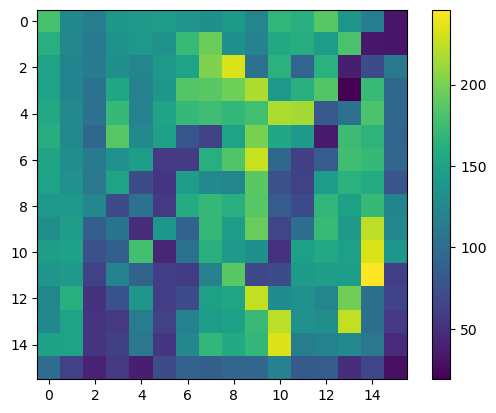

In [25]:
plt.imshow(lf_prediction[0:16,0:16])
plt.colorbar()

In [62]:
def raster_flatten(input_img):
    height = input_img.shape[0]
    width = input_img.shape[1]
    output = np.zeros(height*width//4*3)
    # scan upper right
    output[0:height*width//4] = input_img[0:height//2, width//2:width].flatten()
    # scan lower left
    output[height*width//4:height*width//2] = input_img[height//2:height, 0:width//2].flatten()
    # scan lower right
    output[height*width//2:height*width*3//4] = input_img[height//2:height, width//2:width].flatten()
    return output

def raster_scan(input_img):
    height = input_img.shape[0]
    width = input_img.shape[1]
    flatten_img = np.zeros(input_img.shape[0]*input_img.shape[1])
    # 16*16
    flatten_img[0:height*width//1024] = input_img[0:height//32,0:height//32].flatten()
    # 32 64 128 256 512
    for i in range(1,5):
        flatten_img[height*width//1024*(4**(i-1)):height*width//1024*(4**(i))] = raster_flatten(input_img[0:height//32*(2**(i)),0:height//32*(2**(i))])
    return flatten_img



In [63]:
raster_scanned_img = raster_scan(lf_prediction)

## EZW Encoding

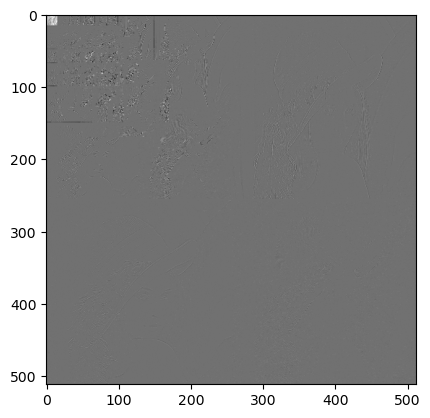

In [10]:
# save l5_decomp_quant to npy
# quantization step = 0.125
l5_decomp_quant = np.round(l5_decomp)
plt.imshow(l5_decomp_quant, cmap='gray')
np.save('l5_decomp_quant.npy', l5_decomp_quant)